In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Senior/Spring/EC523/FinalProject/ec523/data.zip

In [2]:
data_dir = '/content/data'

# What does our Data Look Like?

Sample Video: bwis8n.mpg
Corresponding Annotation: bwis8n.align


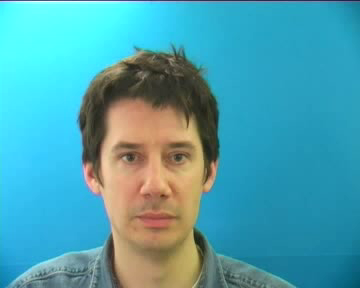


Annotation Content:
0 18250 sil
18250 23250 bin
23250 28500 white
28500 31250 in
31250 36000 s
36000 40500 eight
40500 49250 now
49250 74500 sil



In [3]:
from google.colab.patches import cv2_imshow
import os
import cv2

data_dir = '/content/data'

# function to find corresponding annotation file for a video file
def find_annotation_file(video_file):
    base_name = os.path.splitext(video_file)[0]
    annotation_file = base_name + '.align'
    return annotation_file

# list contents of the data directory
videos_dir = os.path.join(data_dir, 'videos')
annotations_dir = os.path.join(data_dir, 'annotations')

video_files = os.listdir(videos_dir)

sample_video = video_files[0]
sample_annotation = find_annotation_file(sample_video)

print("Sample Video:", sample_video)
print("Corresponding Annotation:", sample_annotation)

# print a frame from the sample video file
video_path = os.path.join(videos_dir, sample_video)
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

# displau frame
cv2_imshow(frame)

# print the corresponding annotation file
annotation_path = os.path.join(annotations_dir, sample_annotation)
with open(annotation_path, 'r') as annotation_file:
    annotation_content = annotation_file.read()
    print("\nAnnotation Content:")
    print(annotation_content)


# Video/Annoation Processing

In [4]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# load video frames
def load_video_frames(video_path, target_size=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
    cap.release()
    return np.array(frames)

# sample video path
sample_video_path = os.path.join(videos_dir, sample_video)

# load video frames
video_frames = load_video_frames(sample_video_path)
print("Number of frames in the video:", len(video_frames))
print("Shape of each frame:", video_frames[0].shape)


# preprocess annotations
def preprocess_annotations(annotation_file, max_length=None):
    with open(annotation_file, 'r') as file:
        annotations = file.readlines()

    # tokenize the text
    tokenizer = Tokenizer(filters='', char_level=True)
    tokenizer.fit_on_texts(annotations)
    sequences = tokenizer.texts_to_sequences(annotations)

    vocab_size = len(tokenizer.word_index) + 1

    # trunc sequences to max_length
    if max_length is not None:
        padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
    else:
        padded_sequences = pad_sequences(sequences, padding='post')

    return padded_sequences, vocab_size

# sample annotation path
sample_annotation_path = os.path.join(annotations_dir, sample_annotation)


max_length = 20
annotation_sequences, vocab_size = preprocess_annotations(sample_annotation_path, max_length=max_length)
print("Preprocessed annotation sequences shape:", annotation_sequences.shape)
print("Vocabulary size:", vocab_size)


Number of frames in the video: 75
Shape of each frame: (224, 224, 3)
Preprocessed annotation sequences shape: (8, 20)
Vocabulary size: 24


# Data Prep

In [5]:
import os
import random
import shutil

#  directories for training and validation set
data_dir = '/content/data'
videos_dir = os.path.join(data_dir, 'videos')
annotations_dir = os.path.join(data_dir, 'annotations')
train_dir = '/content/train_data'
val_dir = '/content/val_data'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# list video files and shuffle
video_files = [file for file in os.listdir(videos_dir) if file.endswith('.mpg')]
random.shuffle(video_files)

# 80 20 split
train_ratio = 0.8
num_train = int(train_ratio * len(video_files))
train_files = video_files[:num_train]
val_files = video_files[num_train:]

# move video files to train directory
for file in train_files:
    video_src = os.path.join(videos_dir, file)
    annotation_src = os.path.join(annotations_dir, file.replace('.mpg', '.align'))
    shutil.copy(video_src, train_dir)
    shutil.copy(annotation_src, train_dir)

# move video files to val directory
for file in val_files:
    video_src = os.path.join(videos_dir, file)
    annotation_src = os.path.join(annotations_dir, file.replace('.mpg', '.align'))
    shutil.copy(video_src, val_dir)
    shutil.copy(annotation_src, val_dir)


In [5]:
print("Number of items in training set:", len(train_files))
print("Number of items in validation set:", len(val_files))

Number of items in training set: 800
Number of items in validation set: 200


# Model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

# encoder layer
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, embedding_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embedding_dim)
        ])
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layer_norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layer_norm2(out1 + ffn_output)

# encoder
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embedding_dim, num_heads, ff_dim, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = layers.Embedding(input_vocab_size, embedding_dim)
        self.pos_encoding = layers.Embedding(maximum_position_encoding, embedding_dim)
        self.enc_layers = [TransformerEncoderLayer(embedding_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)

    def call(self, inputs, training):
        seq_len = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_encoding(positions)
        x = self.embedding(inputs)
        x += position_embeddings
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training)
        return x

# model for lip reading
def create_transformer_model(max_len, vocab_size, num_layers=4, embedding_dim=128, num_heads=8, ff_dim=512, dropout_rate=0.1):
    input_text = layers.Input(shape=(max_len,), name='input_text')
    transformer_encoder = TransformerEncoder(num_layers, embedding_dim, num_heads, ff_dim, vocab_size, max_len, dropout_rate)
    encoded_text = transformer_encoder(input_text)
    output = layers.Dense(vocab_size, activation='softmax', name='output')(encoded_text)
    model = tf.keras.Model(inputs=input_text, outputs=output)
    return model

max_len = 20
vocab_size = 25
transformer_model = create_transformer_model(max_len, vocab_size)
transformer_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_text (InputLayer)     [(None, 20)]              0         
                                                                 
 transformer_encoder (Trans  (None, 20, 128)           2644608   
 formerEncoder)                                                  
                                                                 
 output (Dense)              (None, 20, 25)            3225      
                                                                 
Total params: 2647833 (10.10 MB)
Trainable params: 2647833 (10.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Loading


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# load data from train_dir
def load_data(train_dir, sample_size):
    video_paths = sorted([os.path.join(train_dir, file) for file in os.listdir(train_dir) if file.endswith('.mpg')])
    annotation_paths = sorted([os.path.join(train_dir, file) for file in os.listdir(train_dir) if file.endswith('.align')])
    video_paths_sample = video_paths[:sample_size]
    annotation_paths_sample = annotation_paths[:sample_size]
    return video_paths_sample, annotation_paths_sample

# preprocess data (resize frames, tokenize annotations)
def preprocess_data(video_paths, annotation_paths, max_len):
    video_frames = [load_video_frames(video_path) for video_path in video_paths]
    annotations = [load_annotation(annotation_path, max_len) for annotation_path in annotation_paths]
    return video_frames, annotations


# load vid frames
def load_video_frames(video_path, num_frames=75, target_size=(224, 224)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret or count >= num_frames:
            break
        frame = cv2.resize(frame, target_size)
        frame = frame.astype(np.float32) / 255.0
        frames.append(frame)
        count += 1
    cap.release()
    while len(frames) < num_frames:
        frames.append(np.zeros_like(frames[0]))
    return np.array(frames)

# load annotation and tokenize
def load_annotation(annotation_path, max_len):
    with open(annotation_path, 'r') as file:
        annotation = file.read().strip().split()
    tokenizer = Tokenizer(filters='', char_level=True)
    tokenizer.fit_on_texts(annotation)
    sequence = tokenizer.texts_to_sequences(annotation)[0]
    sequence = pad_sequences([sequence], maxlen=max_len, padding='post', truncating='post')[0]
    return sequence



# Training!


In [15]:
#. hyperparameters

max_len = 20
vocab_size = 25
num_layers = 2
embedding_dim = 64
num_heads = 4
ff_dim = 256
dropout_rate = 0.1
batch_size = 16
epochs = 10


sample_size = 200  # used a small sample size since ram crashing!
video_paths, annotation_paths = load_data(train_dir, sample_size)

video_frames, annotations = preprocess_data(video_paths, annotation_paths, max_len)

# convert lists to numpy arrays
video_frames = np.array(video_frames)
annotations = np.array(annotations)

transformer_model = create_transformer_model(max_len, vocab_size, num_layers, embedding_dim, num_heads, ff_dim, dropout_rate)
transformer_model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# train
transformer_model.fit(x=annotations, y=annotations, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/10
10/10 [==============================] - 6s 61ms/step - loss: 0.6448 - accuracy: 0.8594 - val_loss: 0.0403 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 12ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/10
10

# Plots

Epoch 1/10
10/10 [==============================] - 0s 18ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 9.9625e-04 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 9.3729e-04 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 8.8379e-04 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.3494e-04 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.9028e-04 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.4930e-04 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 7.1145e-04 - val_ac

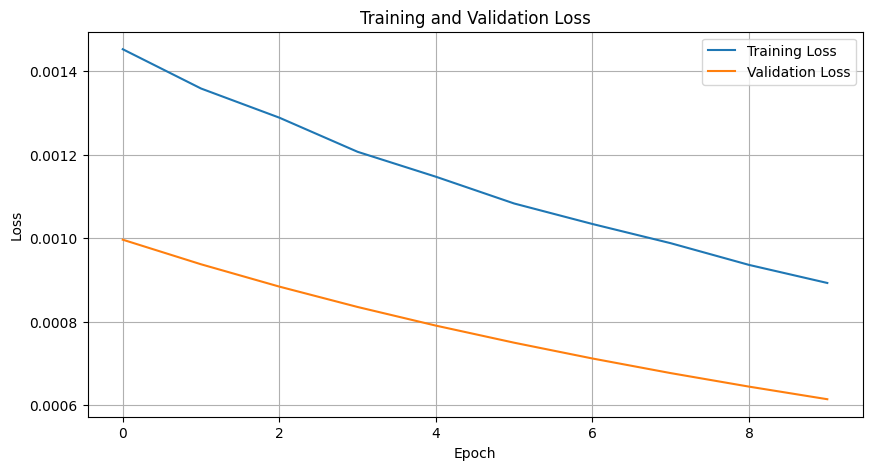

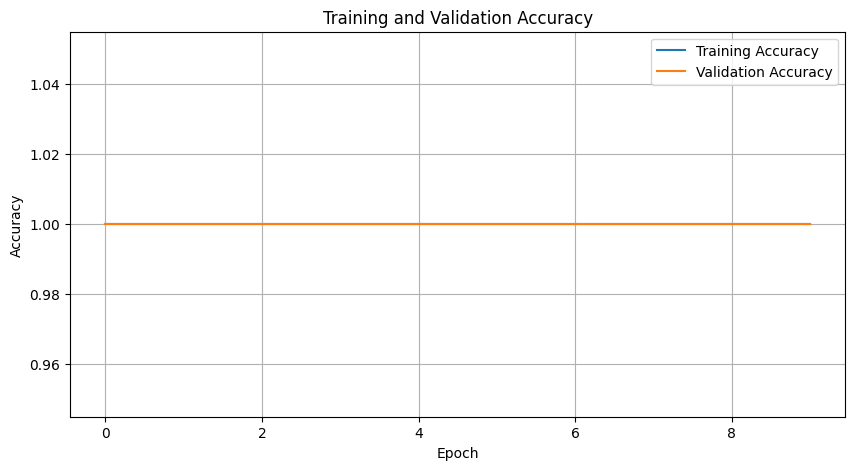

In [16]:
import matplotlib.pyplot as plt


history = transformer_model.fit(x=annotations, y=annotations, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# plot  accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# So I tried running model on the whole dataset, but i kept getting used up all ram crash errror. I decrease sample size to 200 videos and it worked. However training and validcation acc being 100 is sus. Aslo the model isn't really the best!